In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from torch import nn
from torch.nn import functional
from PIL import Image
from torchvision import transforms
from models import Customed_ShallowNet, CAM_CNN, Vgg16
from torch.nn import functional

/DB/rhome/bllai/Envs/PyTorch1.0Env/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

torch.Size([1, 3, 224, 224])


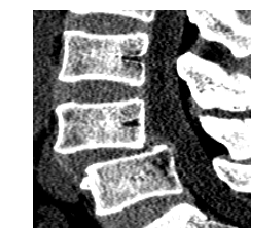

In [4]:
image_path = '/DB/rhome/bllai/Data/DATA5/Vertebrae/Sagittal/SW_revise/Lux_84/2391669/sw113_1.png'
image = Image.open(image_path)
# image = Image.fromarray(np.asarray(image)[:, :, 0])
ax = get_ax(rows=1, cols=1, size=4)
ax.axis('off')
ax.imshow(image)
# trans = transforms.Compose([transforms.Resize((112, 112)), transforms.ToTensor()])
trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image = torch.unsqueeze(trans(image), dim=0).cuda()
print(image.size())

In [5]:
# model = Customed_ShallowNet(num_classes=2)
# model.load('checkpoints/Customed_ShallowNet/Baseline_all_3.pth')
# model = CAM_CNN(num_classes=2)
# model.load('checkpoints/CAM_CNN/CAMCNN_w0.01&0.01_T0.5in224_2.pth')
model = Vgg16(num_classes=2)
model.load('checkpoints/Vgg16/vgg16test/vgg16test.pth')
model.cuda()
model.eval()
print(model)

Vgg16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv

In [6]:
feature = model.features(image)
print(feature.size())

torch.Size([1, 512, 7, 7])


In [7]:
classifier_1 = model.classifier[0]
relu_1 = model.classifier[1]
classifier_2 = model.classifier[3]
relu_2 = model.classifier[4]
classifier_3 = model.classifier[6]

In [8]:
feature = feature.view(feature.size(0), -1)
score = classifier_3(relu_2(classifier_2(relu_1(classifier_1(feature)))))
print(score)
softmax = functional.softmax
prob = softmax(score, dim=1)
print(prob)

tensor([[ 0.0912, -0.1103]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.5502, 0.4498]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [9]:
ref1 = classifier_1(feature)
ref2 = classifier_2(relu_1(ref1))
r1 = torch.diag_embed(torch.where(ref1 > 0, torch.Tensor([1]).cuda(), torch.Tensor([0]).cuda()))
r2 = torch.diag_embed(torch.where(ref2 > 0, torch.Tensor([1]).cuda(), torch.Tensor([0]).cuda()))
weight1 = classifier_1.weight
bias1 = classifier_1.bias
weight2 = classifier_2.weight
bias2 = classifier_2.bias
weight3 = classifier_3.weight
bias3 = classifier_3.bias
feature = feature.unsqueeze(-1)
weight1 = torch.cat([weight1.unsqueeze(0)] * feature.size(0))
weight2 = torch.cat([weight2.unsqueeze(0)] * feature.size(0))
weight3 = torch.cat([weight3.unsqueeze(0)] * feature.size(0))
bias1 = bias1.unsqueeze(-1)
bias2 = bias2.unsqueeze(-1)
bias3 = bias3.unsqueeze(-1)
print('feature:', feature.size())
print('r1:', r1.size())
print('r2:', r2.size())
print('weight1:', weight1.size())
print('weight2:', weight2.size())
print('weight3:', weight3.size())
print('bias1:', bias1.size())
print('bias2:', bias2.size())
print('bias3:', bias3.size())

feature: torch.Size([1, 25088, 1])
r1: torch.Size([1, 4096, 4096])
r2: torch.Size([1, 4096, 4096])
weight1: torch.Size([1, 4096, 25088])
weight2: torch.Size([1, 4096, 4096])
weight3: torch.Size([1, 2, 4096])
bias1: torch.Size([4096, 1])
bias2: torch.Size([4096, 1])
bias3: torch.Size([2, 1])


In [10]:
selfcal_score = torch.bmm(weight3, torch.bmm(r2, torch.bmm(weight2, torch.bmm(r1, torch.bmm(weight1, feature)+bias1))+bias2))+bias3
print(selfcal_score.squeeze(-1))
print(softmax(selfcal_score.squeeze(-1), dim=1))
chain_grad = torch.bmm(weight3, torch.bmm(r2, torch.bmm(weight2, torch.bmm(r1, weight1))))
print(chain_grad.size())
print(chain_grad[:, 0].size())

tensor([[ 0.0912, -0.1103]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([[0.5502, 0.4498]], device='cuda:0', grad_fn=<SoftmaxBackward>)
torch.Size([1, 2, 25088])
torch.Size([1, 25088])


tensor(0.0338, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0198, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0035, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0128, device='cuda:0', grad_fn=<MaxBackward1>)


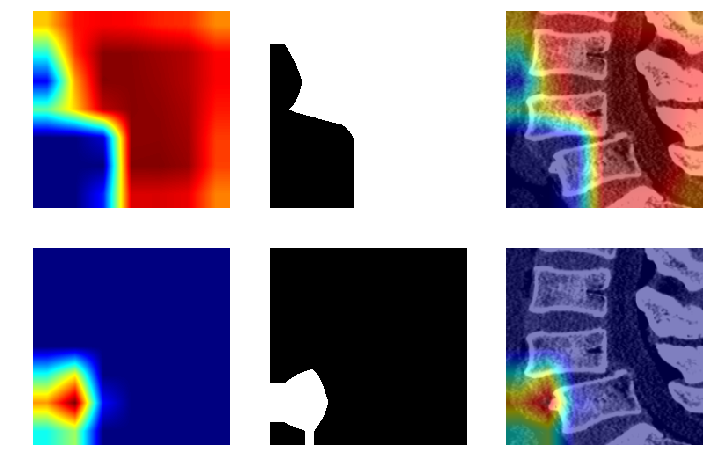

In [11]:
gap= nn.AvgPool2d(kernel_size=7)
relu = nn.ReLU(inplace=True)
w0 = gap(chain_grad[:, 0].view(-1, 512, 7, 7))
w1 = gap(chain_grad[:, 1].view(-1, 512, 7, 7))

cam_0 = relu(torch.sum(feature.view(-1, 512, 7, 7) * w0, dim=1, keepdim=True))
cam_1 = relu(torch.sum(feature.view(-1, 512, 7, 7) * w1, dim=1, keepdim=True))

print(torch.max(w0), torch.max(w1))
print(torch.max(cam_0), torch.max(cam_1))
cam_0 = functional.interpolate(cam_0, size=(224, 224), mode='bilinear', align_corners=False)
cam_1 = functional.interpolate(cam_1, size=(224, 224), mode='bilinear', align_corners=False)
cam_0 = cam_0 - torch.min(torch.min(cam_0, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_0 = cam_0 / torch.max(torch.max(cam_0, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_1 = cam_1 - torch.min(torch.min(cam_1, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_1 = cam_1 / torch.max(torch.max(cam_1, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_0 = torch.where(cam_0 > 0.001, cam_0, torch.Tensor([0.001]).cuda())
cam_1 = torch.where(cam_1 > 0.001, cam_1, torch.Tensor([0.001]).cuda())

t_cam_0 = (cam_0 > 0.5).int()
t_cam_1 = (cam_1 > 0.5).int()

cam_0 = cam_0.cpu().detach().numpy()[0][0]
cam_1 = cam_1.cpu().detach().numpy()[0][0]
t_cam_0 = t_cam_0.cpu().detach().numpy()[0][0]
t_cam_1 = t_cam_1.cpu().detach().numpy()[0][0]

ax = get_ax(rows=2, cols=3, size=4)
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[0][2].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[1][2].axis('off')

heatmap_0 = cv2.applyColorMap(np.uint8(255 * cam_0), cv2.COLORMAP_JET)
heatmap_1 = cv2.applyColorMap(np.uint8(255 * cam_1), cv2.COLORMAP_JET)
ax[0][0].imshow(heatmap_0[:, :, ::-1])
ax[1][0].imshow(heatmap_1[:, :, ::-1])
ax[0][1].imshow(Image.fromarray(255 * t_cam_0))
ax[1][1].imshow(Image.fromarray(255 * t_cam_1))

img = cv2.resize(cv2.imread(image_path, 1), (224, 224))  # 这一步重新读入图片是为了将CAM图画在原图上
cam_0 = np.float32(heatmap_0) / 255 + np.float32(img) / 255
cam_1 = np.float32(heatmap_1) / 255 + np.float32(img) / 255
cam_0 = np.uint8(255 * cam_0 / np.max(cam_0))
cam_1 = np.uint8(255 * cam_1 / np.max(cam_1))
ax[0][2].imshow(cam_0[:, :, ::-1])
ax[1][2].imshow(cam_1[:, :, ::-1])
plt.show()

In [12]:
ref1 = classifier_1(feature)
ref2 = classifier_2(relu_1(ref1))
r1 = torch.diag_embed(torch.where(ref1 > 0, torch.Tensor([1]).cuda(), torch.Tensor([0]).cuda()))
r2 = torch.diag_embed(torch.where(ref2 > 0, torch.Tensor([1]).cuda(), torch.Tensor([0]).cuda()))
print(r2.size())
weight1 = classifier_1.weight
weight2 = classifier_2.weight
weight3 = classifier_3.weight
b = torch.rand((1, 25088, 2)).cuda()
c = torch.rand((1, 5, 1)).cuda()
print(weight1.size())
print(torch.cat([weight1.unsqueeze(0)] * 16).size())
trans_grad = torch.matmul(weight3, torch.matmul(r2, torch.matmul(weight2, torch.matmul(r1, torch.matmul(weight1, feature.transpose(0, 1))))))
print(trans_grad)
a = torch.sum(trans_grad)

RuntimeError: size mismatch, m1: [25088 x 1], m2: [25088 x 4096] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266

In [31]:
# print(classifier_1(feature))
# print(relu_1(classifier_1(feature)))
print(feature.size())
print(classifier_1.weight.size())
print(classifier_1(feature).t().size())
x = torch.randn(2, 5).cuda()
x.requires_grad=True
print(x)
print(torch.diag_embed(x))

torch.Size([1, 25088])
torch.Size([4096, 25088])
torch.Size([4096, 1])
tensor([[ 0.0789, -0.1345,  1.7747,  0.8509,  1.5710],
        [ 1.3155, -1.0653, -0.3474,  1.9343,  1.0231]], device='cuda:0',
       requires_grad=True)
tensor([[[ 0.0789,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.1345,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.7747,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.8509,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  1.5710]],

        [[ 1.3155,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.0653,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.3474,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.9343,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0231]]], device='cuda:0',
       grad_fn=<CopySlices>)
tensor([[ 0.1578, -0.2690,  3.5493,  1.7018,  3.1419],
        [ 2.6310, -2.1306, -0.6947,  3.8687,  2.0461]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [92]:
conv1_1 = nn.Sequential(model.features[0], model.features[1])
conv1_2 = nn.Sequential(model.features[2], model.features[3], model.features[4])
conv2_1 = nn.Sequential(model.features[5], model.features[6])
conv2_2 = nn.Sequential(model.features[7], model.features[8], model.features[9])
conv3_1 = nn.Sequential(model.features[10], model.features[11])
conv3_2 = nn.Sequential(model.features[12], model.features[13])
conv3_3 = nn.Sequential(model.features[14], model.features[15], model.features[16])
conv4_1 = nn.Sequential(model.features[17], model.features[18])
conv4_2 = nn.Sequential(model.features[19], model.features[20])
conv4_3 = nn.Sequential(model.features[21], model.features[22], model.features[23])
classifier = model.classifier

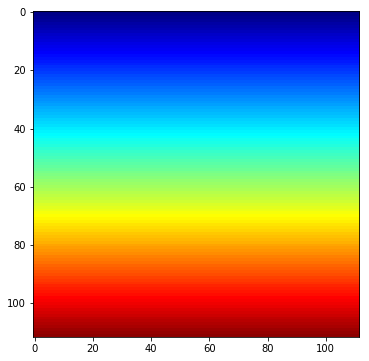

In [93]:
test = np.zeros((112, 112))
for item in range(112):
    test[item] = item / 112 * 255
test = cv2.applyColorMap(np.uint8(test), cv2.COLORMAP_JET)[:, :, ::-1]
ax = get_ax(rows=1, cols=1, size=6)
ax.imshow(test)

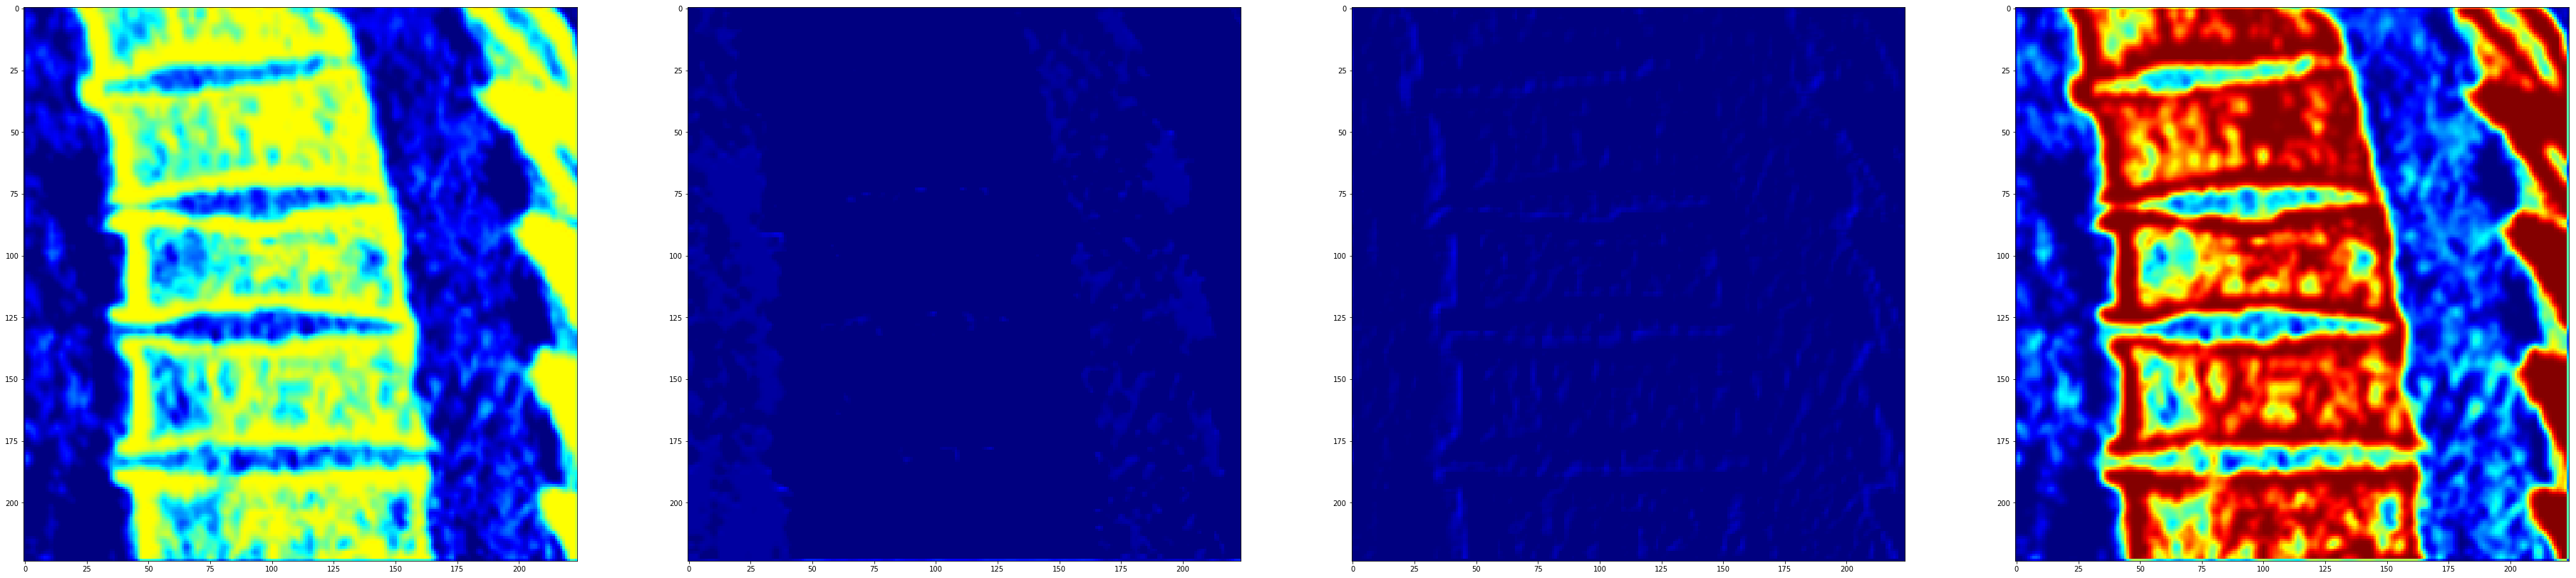

In [94]:
feature = conv1_1(image)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=1, cols=4)
for i in range(len(feat)):
    ax[i].imshow(feat[i])
plt.show()

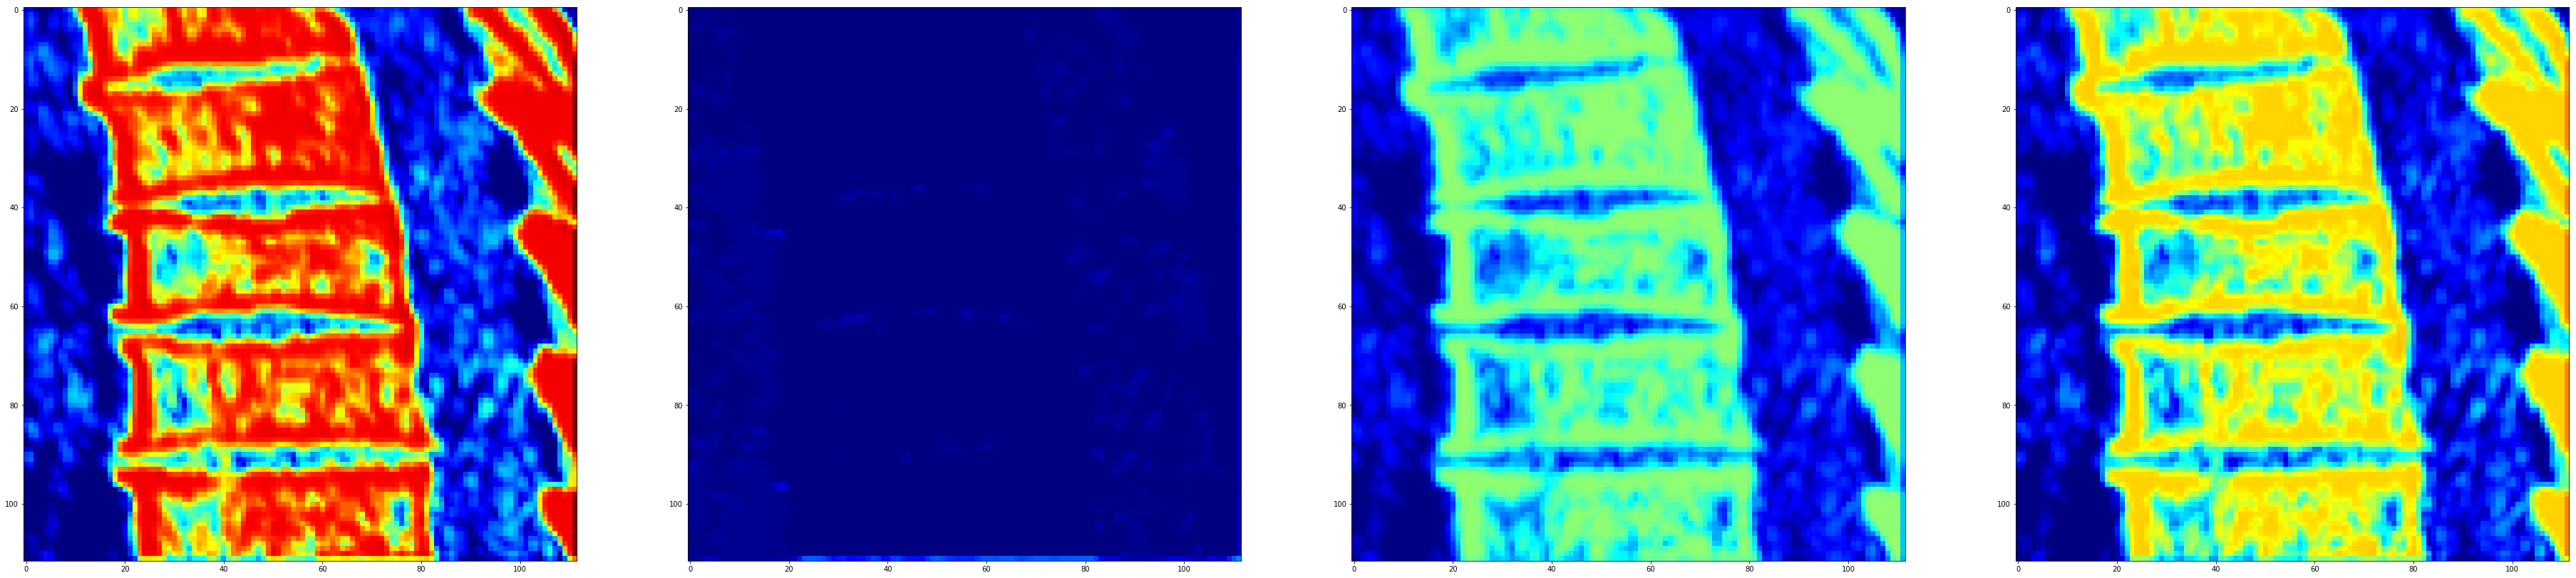

In [95]:
feature = conv1_2(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=1, cols=4)
for i in range(len(feat)):
    ax[i].imshow(feat[i])
plt.show()

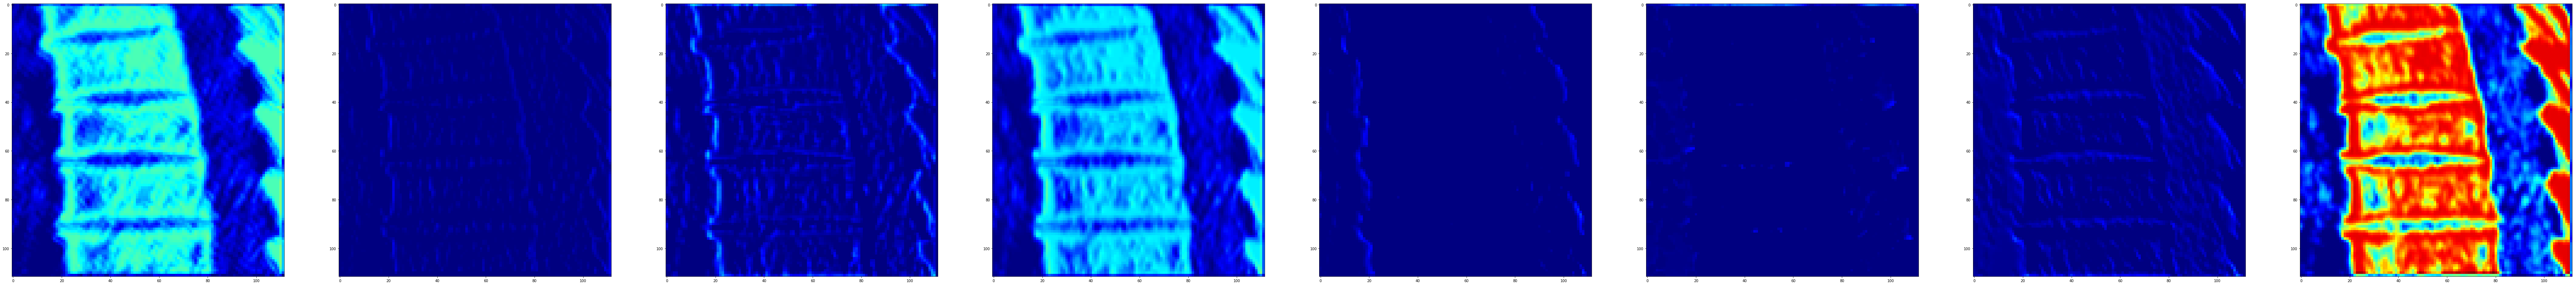

In [96]:
feature = conv2_1(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=1, cols=8)
for i in range(len(feat)):
    ax[i].imshow(feat[i])
plt.show()

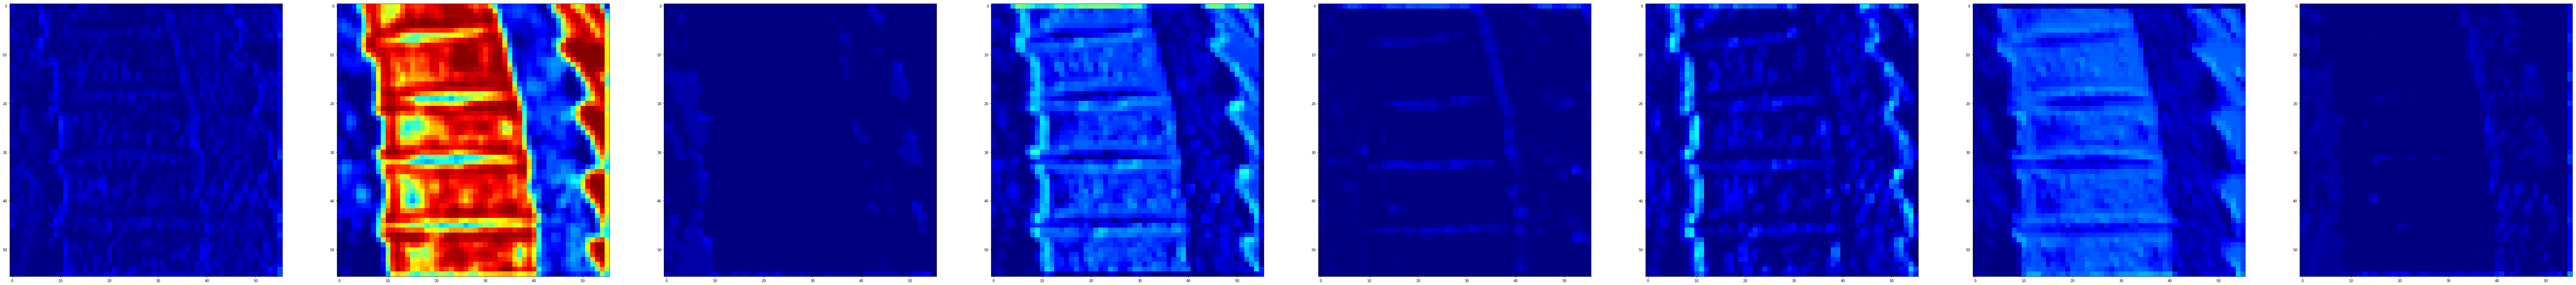

In [97]:
feature = conv2_2(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=1, cols=8)
for i in range(len(feat)):
    ax[i].imshow(feat[i])
plt.show()

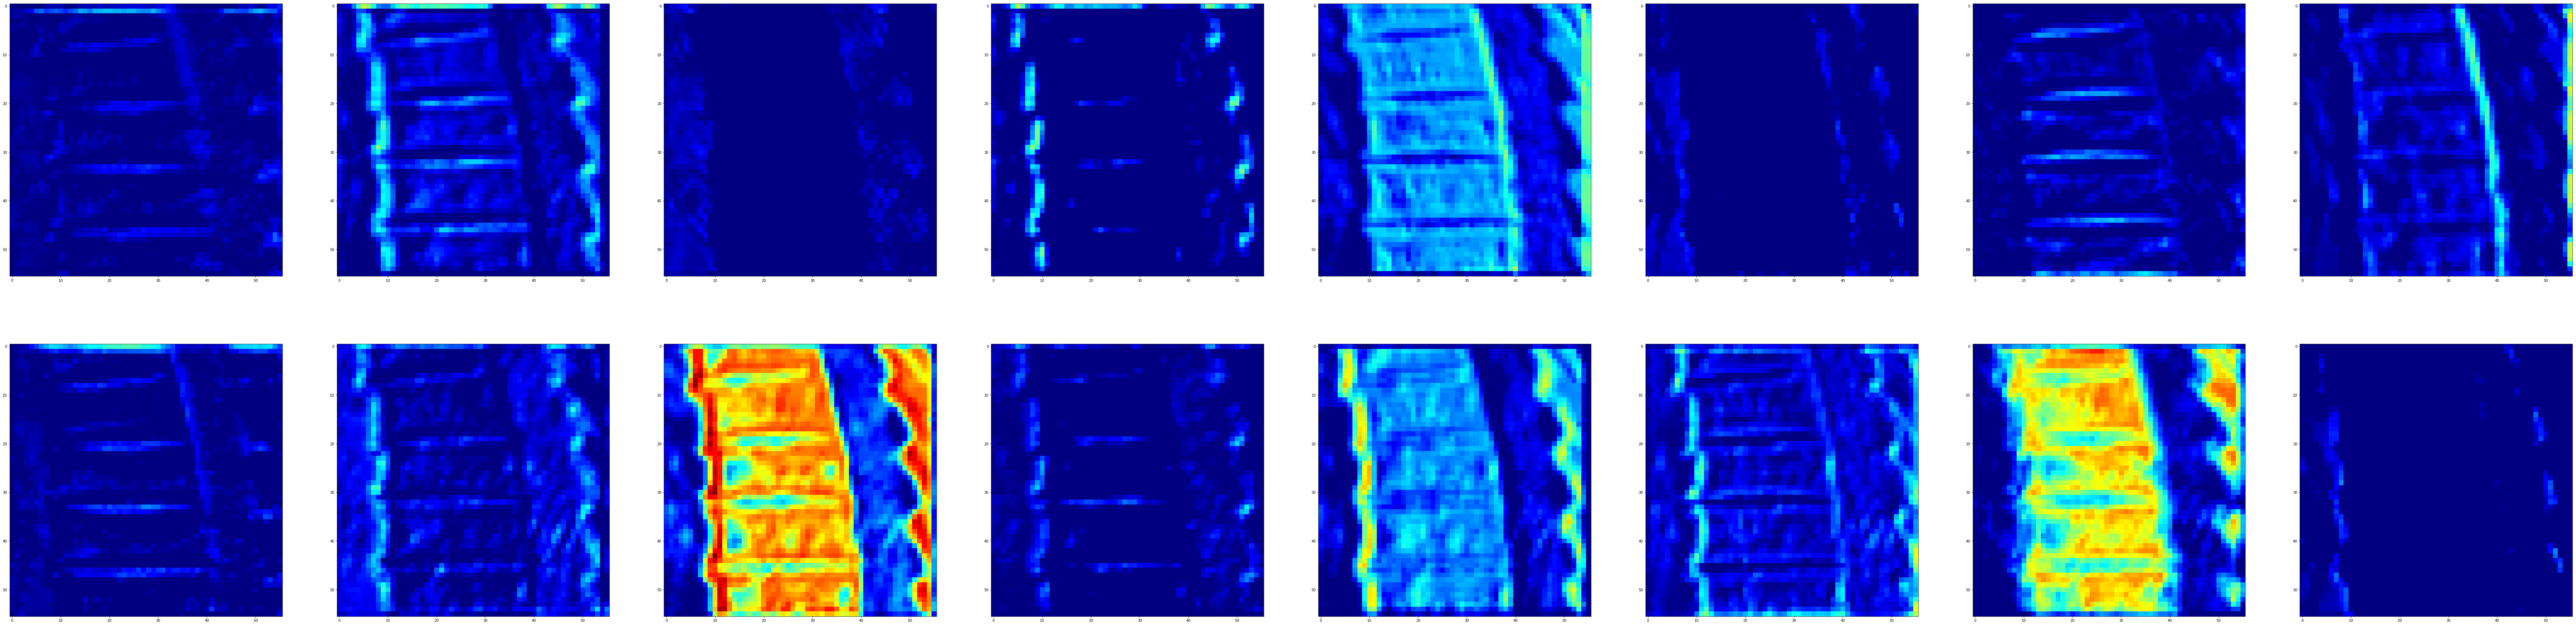

In [98]:
feature = conv3_1(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=2, cols=8)
for i in range(len(feat)):
    ax[i//8][i%8].imshow(feat[i])
plt.show()

# feat_numpy = np.array([cv2.resize(item, (112, 112)) for item in feat_numpy[0]])  # 16*112*112
# feat_numpy[feat_numpy > 0.4*255] = 255
# feat_numpy[feat_numpy <= 0.4*255] = 0
# ax = get_ax(rows=2, cols=8)
# for i in range(feat_numpy.shape[0]):
#     ax[i//8][i%8].imshow(Image.fromarray(feat_numpy[i]))
# plt.show()

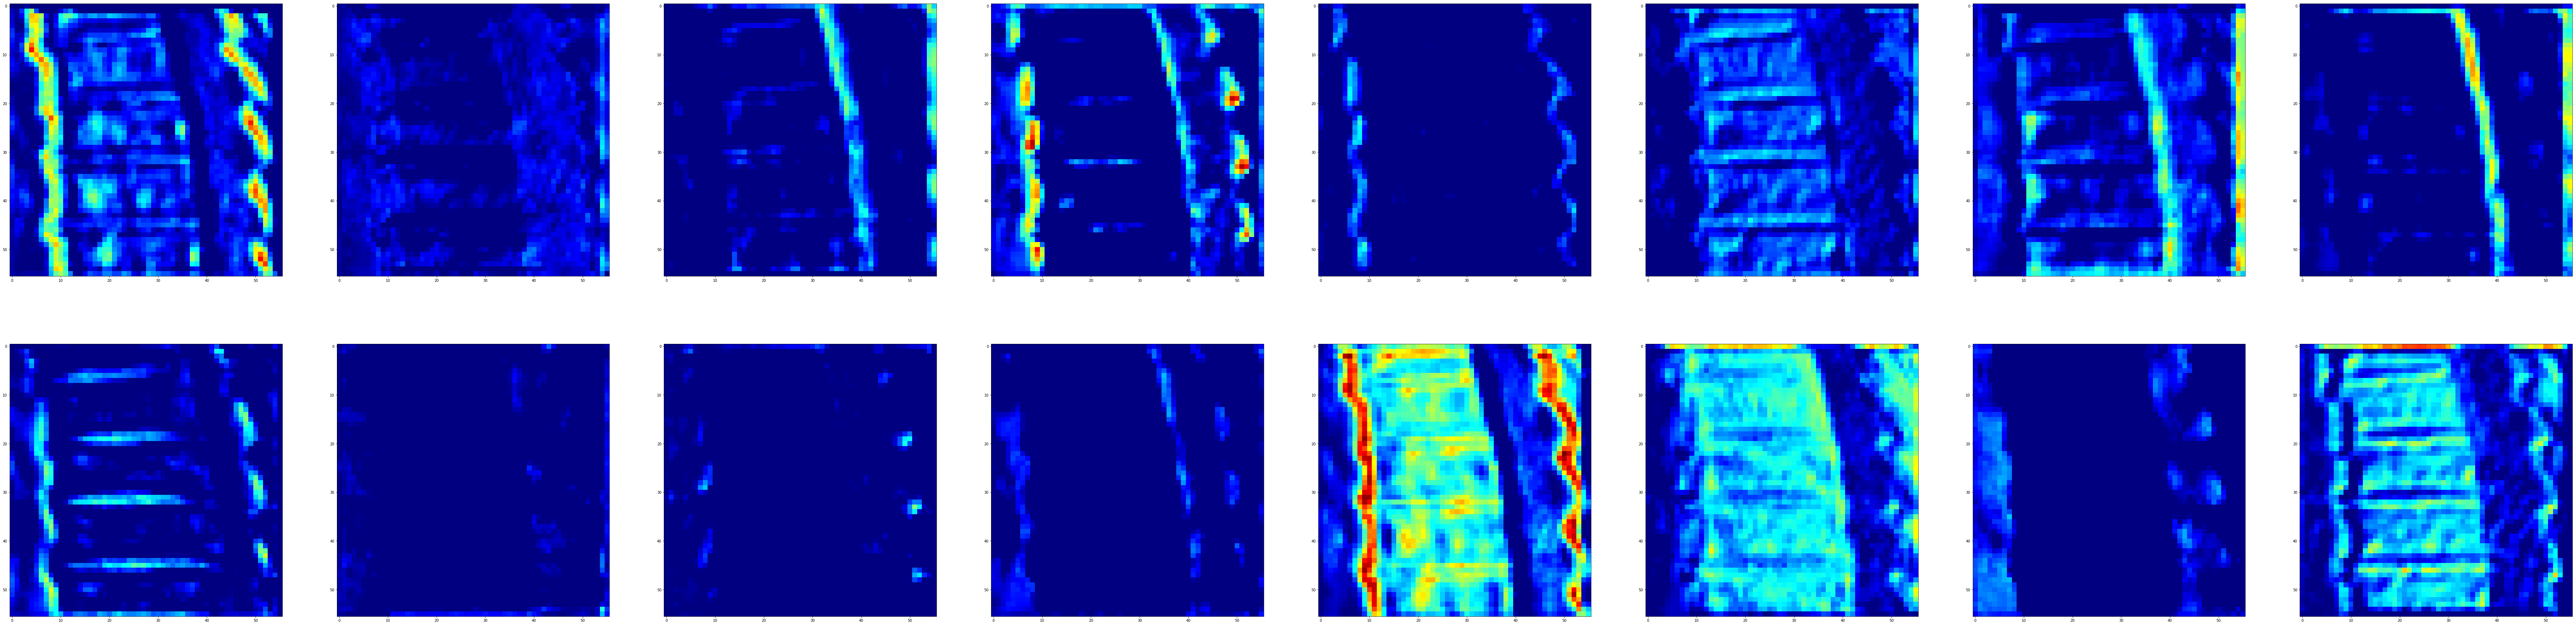

In [99]:
feature = conv3_2(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=2, cols=8)
for i in range(len(feat)):
    ax[i//8][i%8].imshow(feat[i])
plt.show()

# feat_numpy = np.array([cv2.resize(item, (112, 112)) for item in feat_numpy[0]])  # 16*112*112
# feat_numpy[feat_numpy > 0.4*255] = 255
# feat_numpy[feat_numpy <= 0.4*255] = 0
# ax = get_ax(rows=2, cols=8)
# for i in range(feat_numpy.shape[0]):
#     ax[i//8][i%8].imshow(Image.fromarray(feat_numpy[i]))
# plt.show()

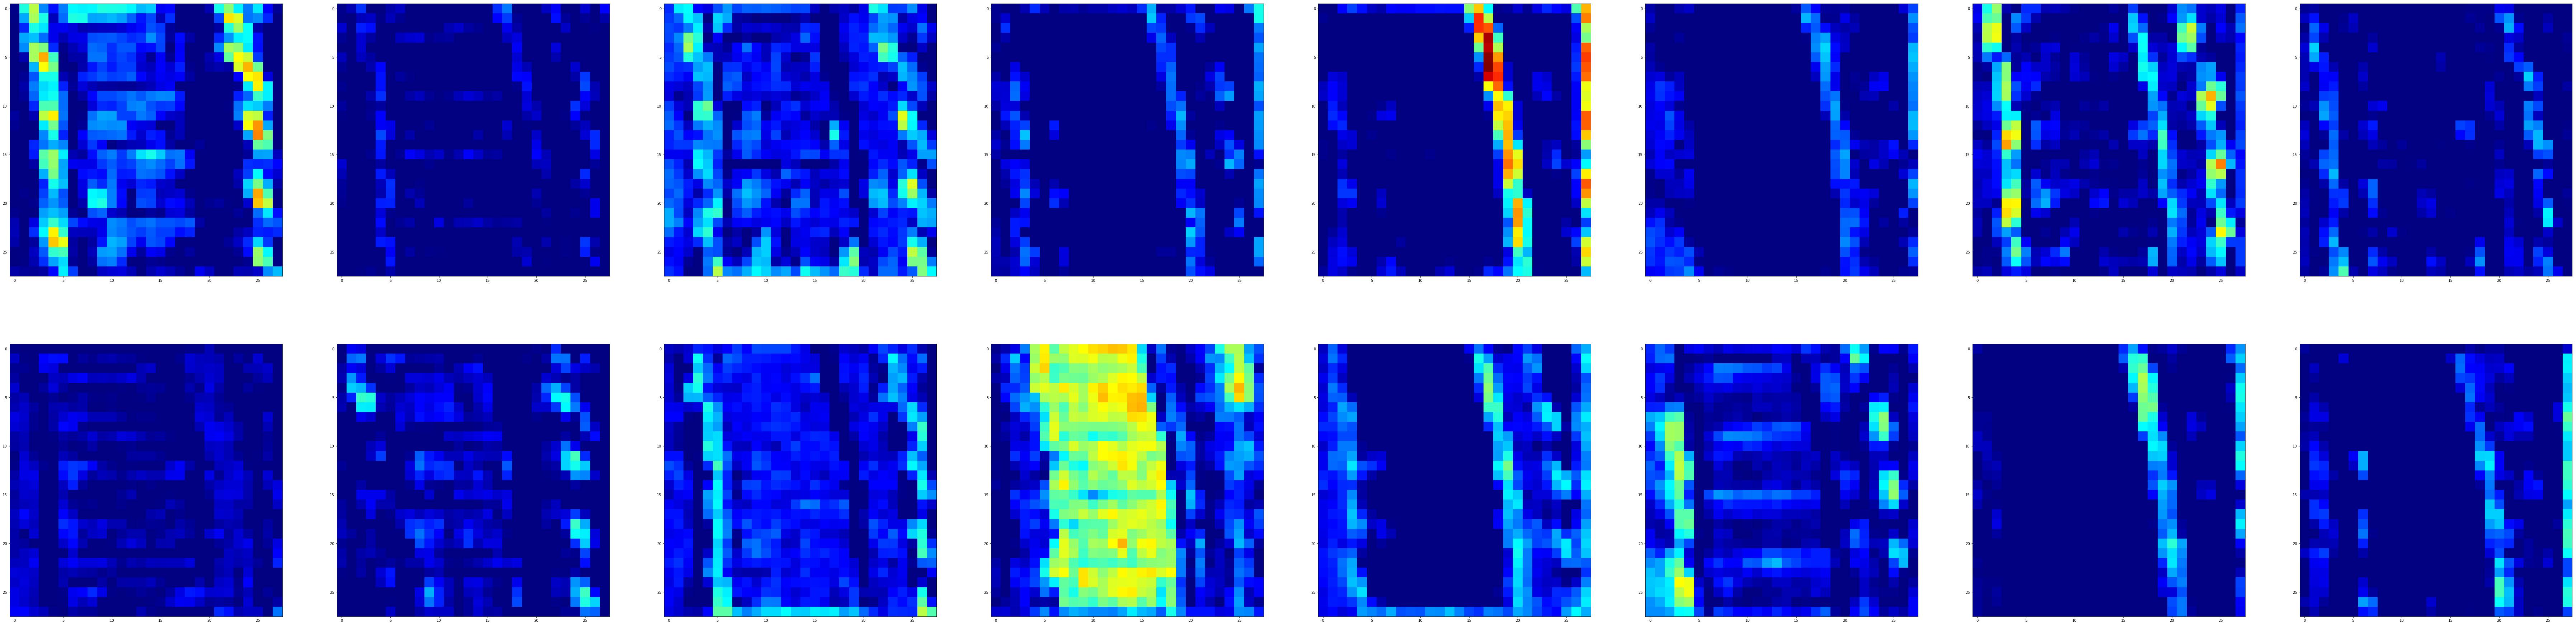

In [100]:
feature = conv3_3(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=2, cols=8)
for i in range(len(feat)):
    ax[i//8][i%8].imshow(feat[i])
plt.show()

# feat_numpy = np.array([cv2.resize(item, (112, 112)) for item in feat_numpy[0]])  # 16*112*112
# feat_numpy[feat_numpy > 0.4*255] = 255
# feat_numpy[feat_numpy <= 0.4*255] = 0
# ax = get_ax(rows=2, cols=8)
# for i in range(feat_numpy.shape[0]):
#     ax[i//8][i%8].imshow(Image.fromarray(feat_numpy[i]))
# plt.show()

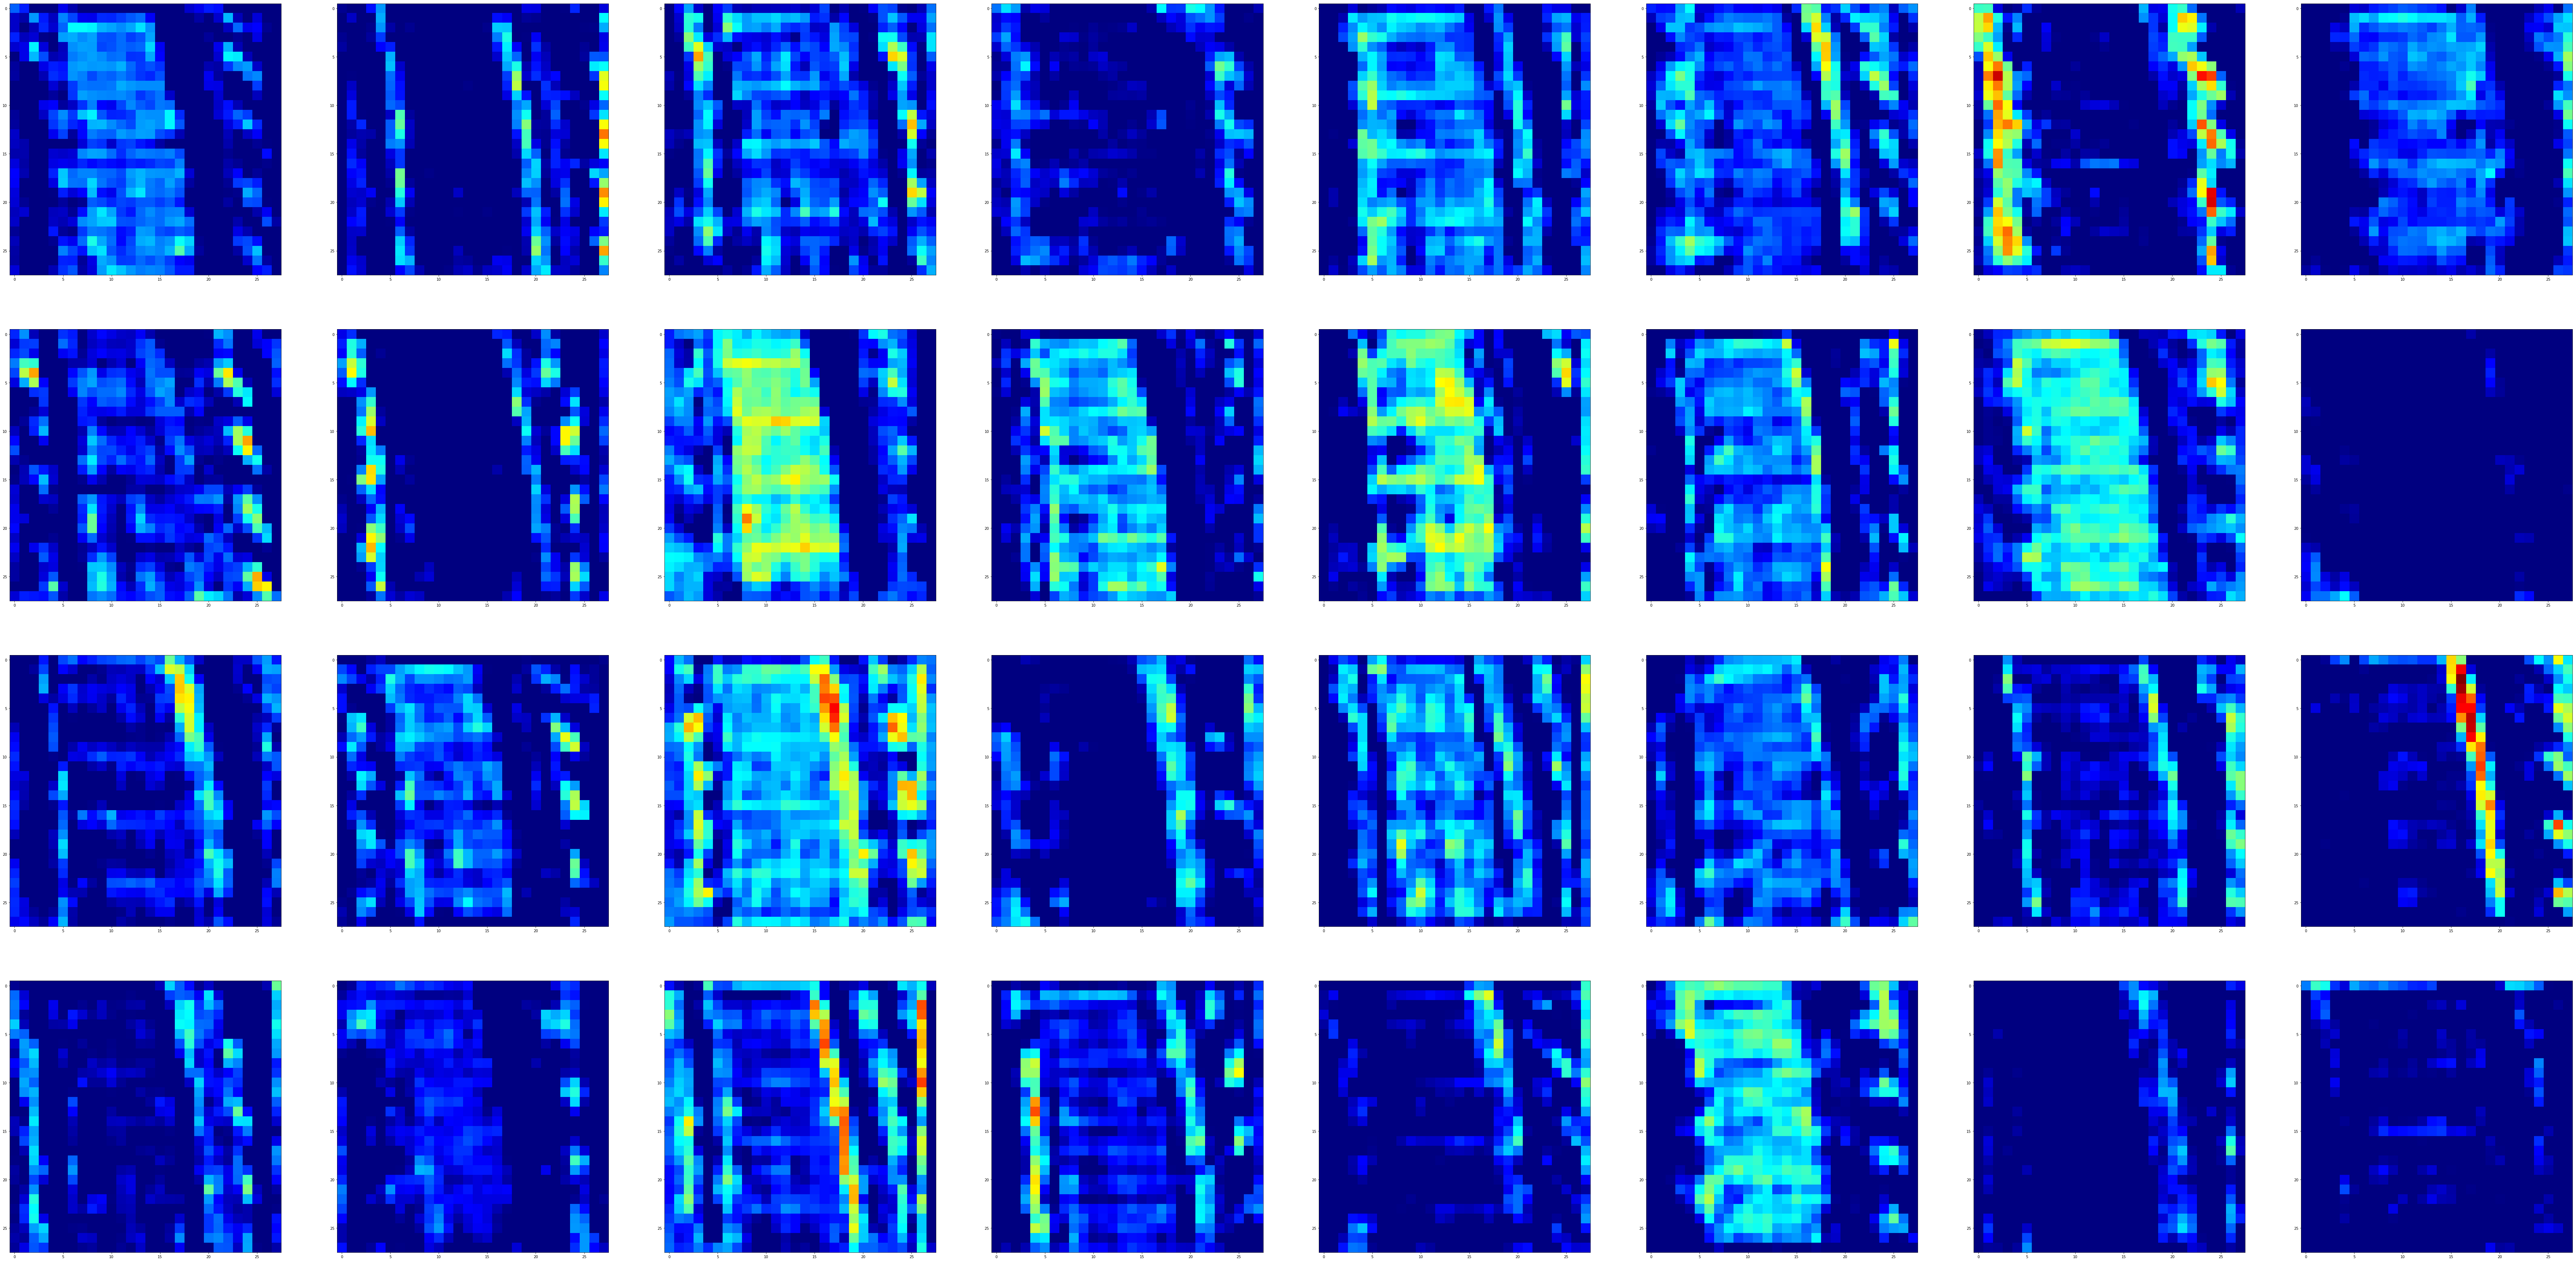

In [101]:
feature = conv4_1(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=4, cols=8)
for i in range(len(feat)):
    ax[i//8][i%8].imshow(feat[i])
plt.show()

# feat_numpy = np.array([cv2.resize(item, (112, 112)) for item in feat_numpy[0]])  # 16*112*112
# feat_numpy[feat_numpy > 0.4*255] = 255
# feat_numpy[feat_numpy <= 0.4*255] = 0
# ax = get_ax(rows=4, cols=8)
# for i in range(feat_numpy.shape[0]):
#     ax[i//8][i%8].imshow(Image.fromarray(feat_numpy[i]))
# plt.show()

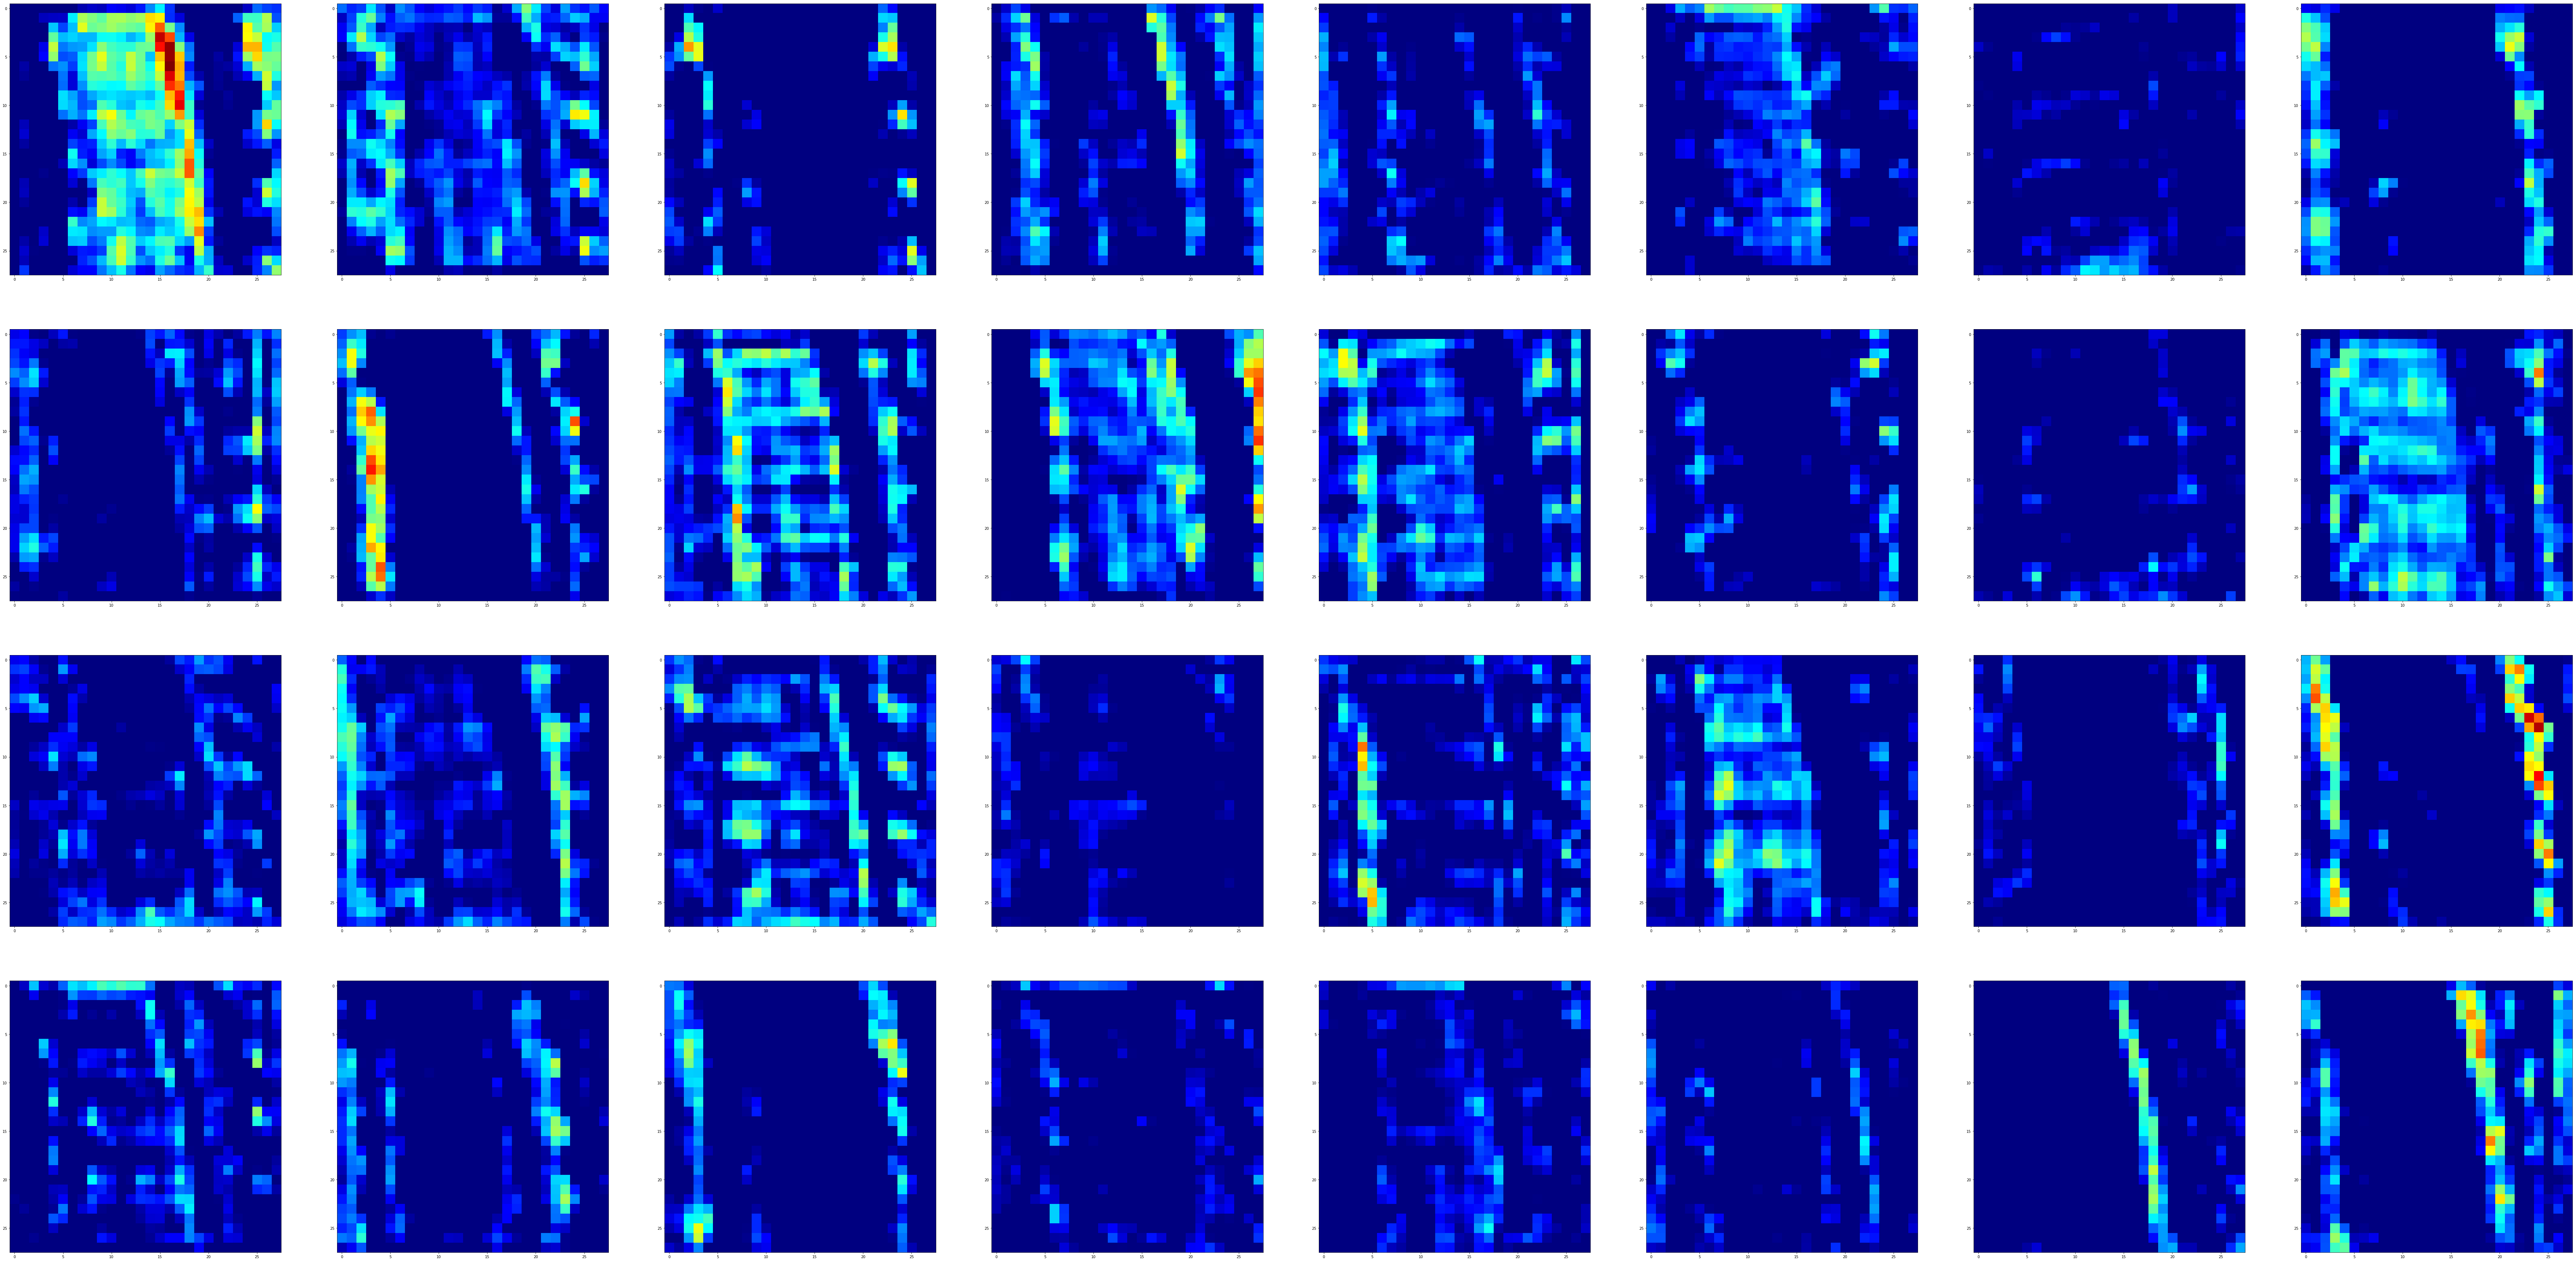

In [102]:
feature = conv4_2(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=4, cols=8)
for i in range(len(feat)):
    ax[i//8][i%8].imshow(feat[i])
plt.show()

# feat_numpy = np.array([cv2.resize(item, (112, 112)) for item in feat_numpy[0]])  # 16*112*112
# feat_numpy[feat_numpy > 0.4*255] = 255
# feat_numpy[feat_numpy <= 0.4*255] = 0
# ax = get_ax(rows=4, cols=8)
# for i in range(feat_numpy.shape[0]):
#     ax[i//8][i%8].imshow(Image.fromarray(feat_numpy[i]))
# plt.show()

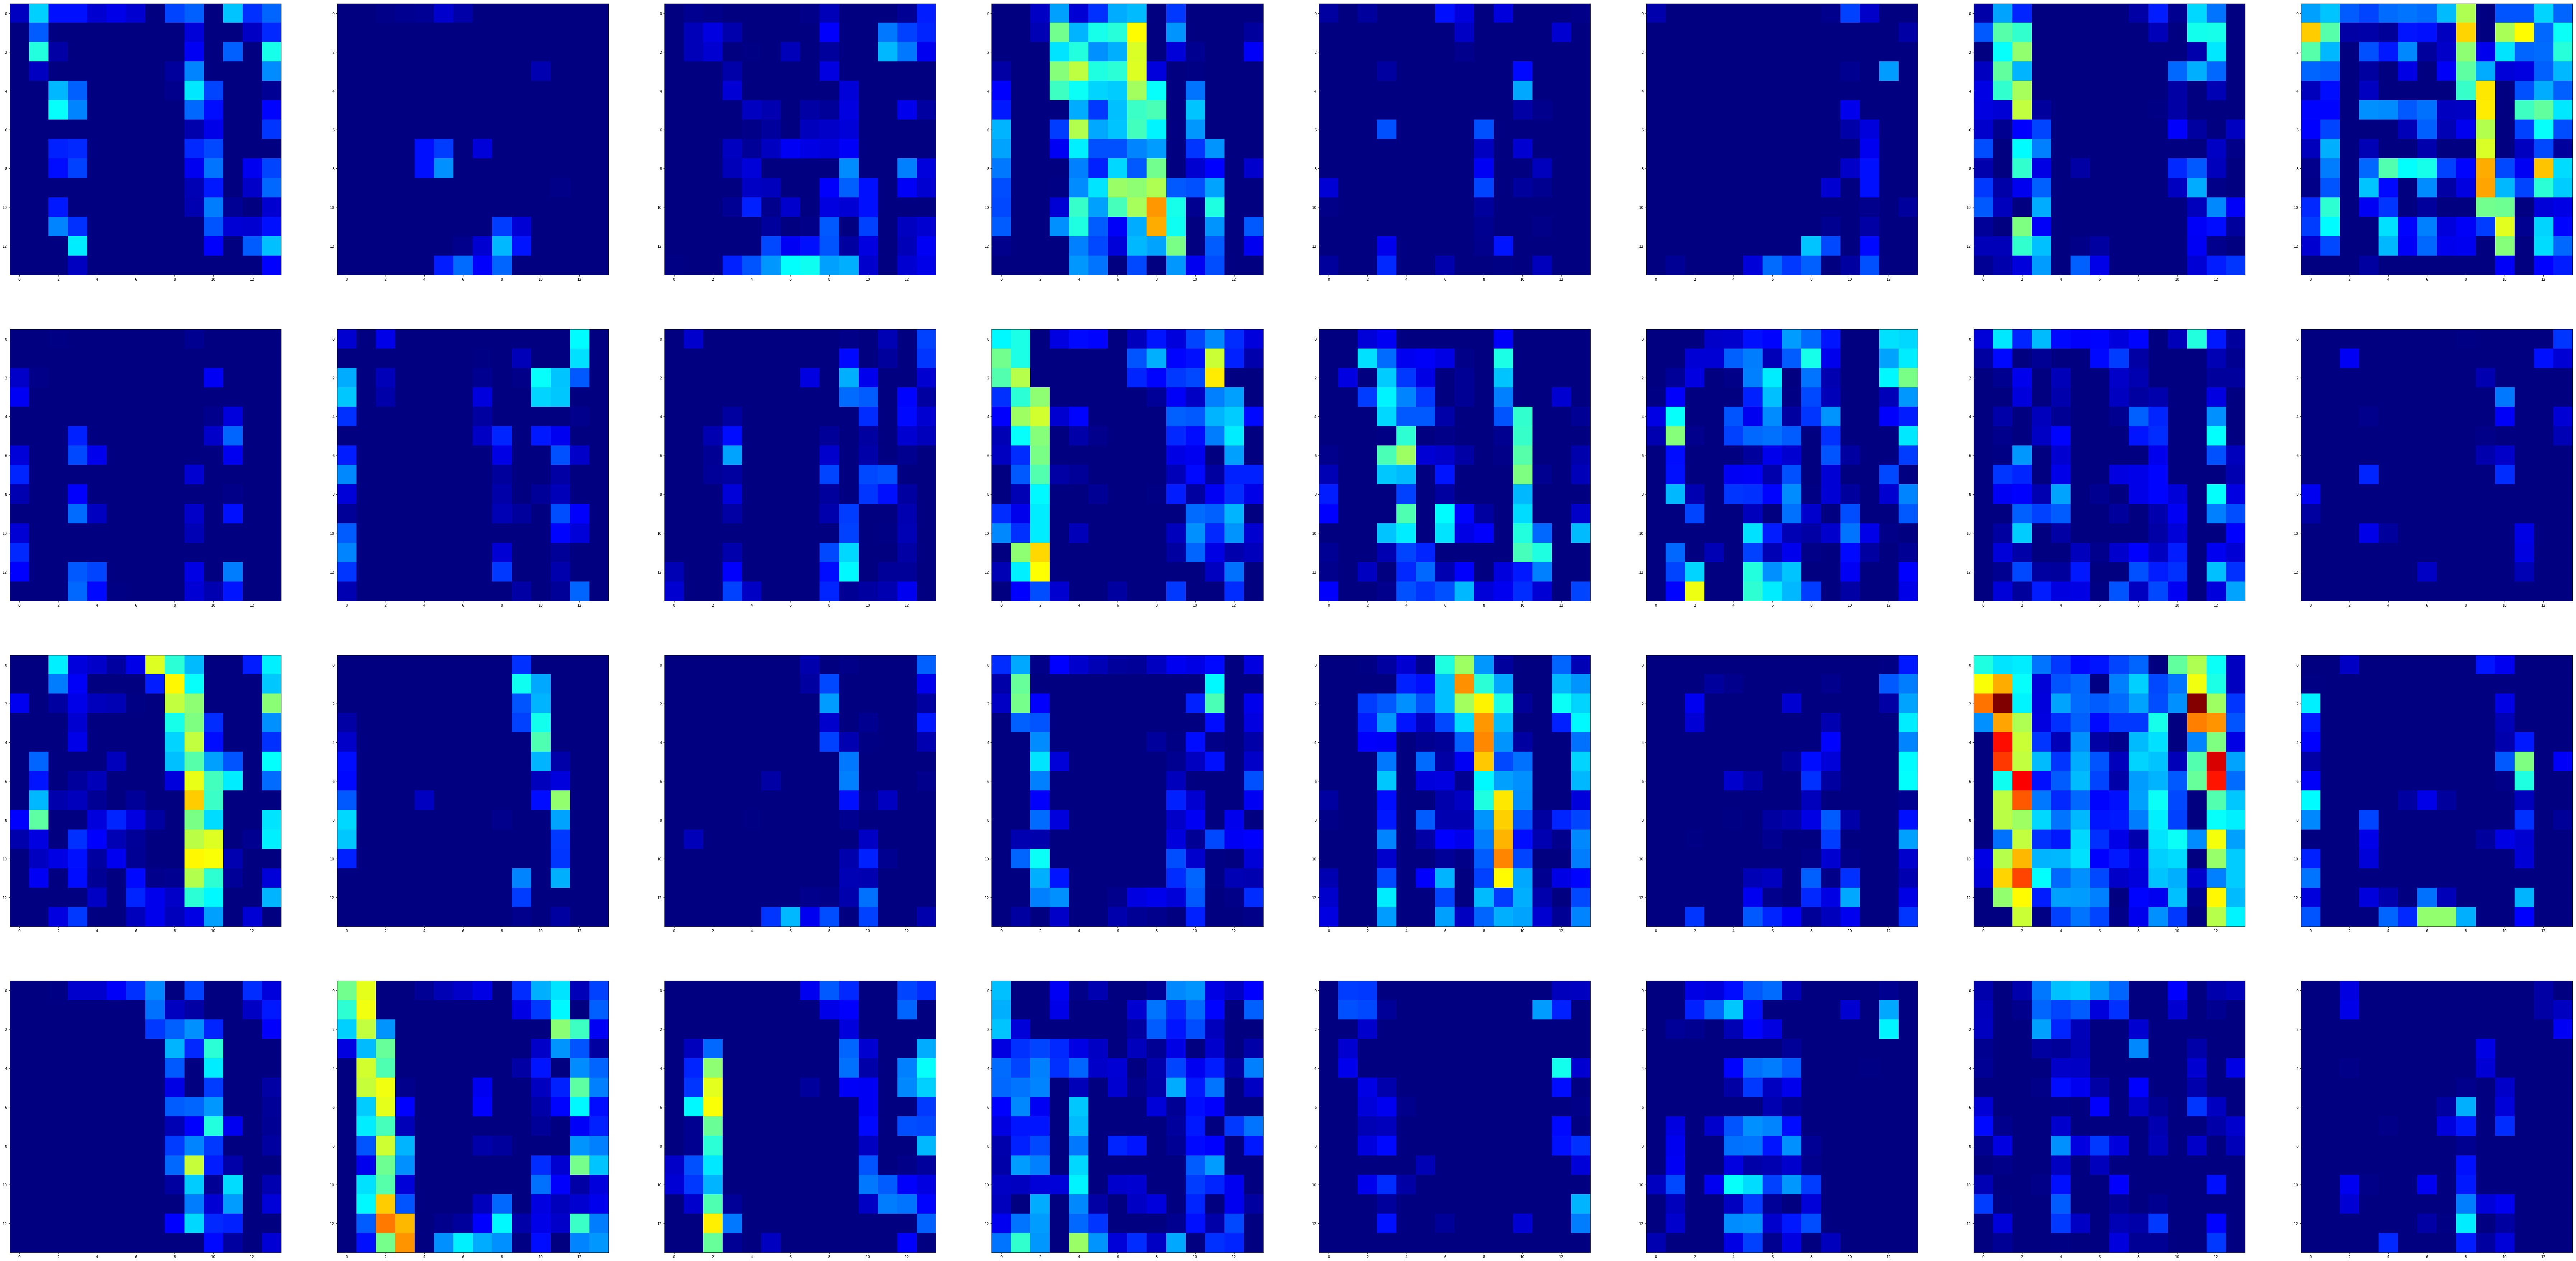

In [103]:
feature = conv4_3(feature)
feat_numpy = feature.detach().cpu().numpy()
feat_numpy = (feat_numpy - np.min(feat_numpy)) / np.max(feat_numpy) * 255
feat = [cv2.applyColorMap(np.uint8(feat_numpy[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(feat_numpy.shape[1])]

ax = get_ax(rows=4, cols=8)
for i in range(len(feat)):
    ax[i//8][i%8].imshow(feat[i])
plt.show()

# feat_numpy = np.array([cv2.resize(item, (112, 112)) for item in feat_numpy[0]])  # 16*112*112
# feat_numpy[feat_numpy > 0.4*255] = 255
# feat_numpy[feat_numpy <= 0.4*255] = 0
# ax = get_ax(rows=4, cols=8)
# for i in range(feat_numpy.shape[0]):
#     ax[i//8][i%8].imshow(Image.fromarray(feat_numpy[i]))
# plt.show()

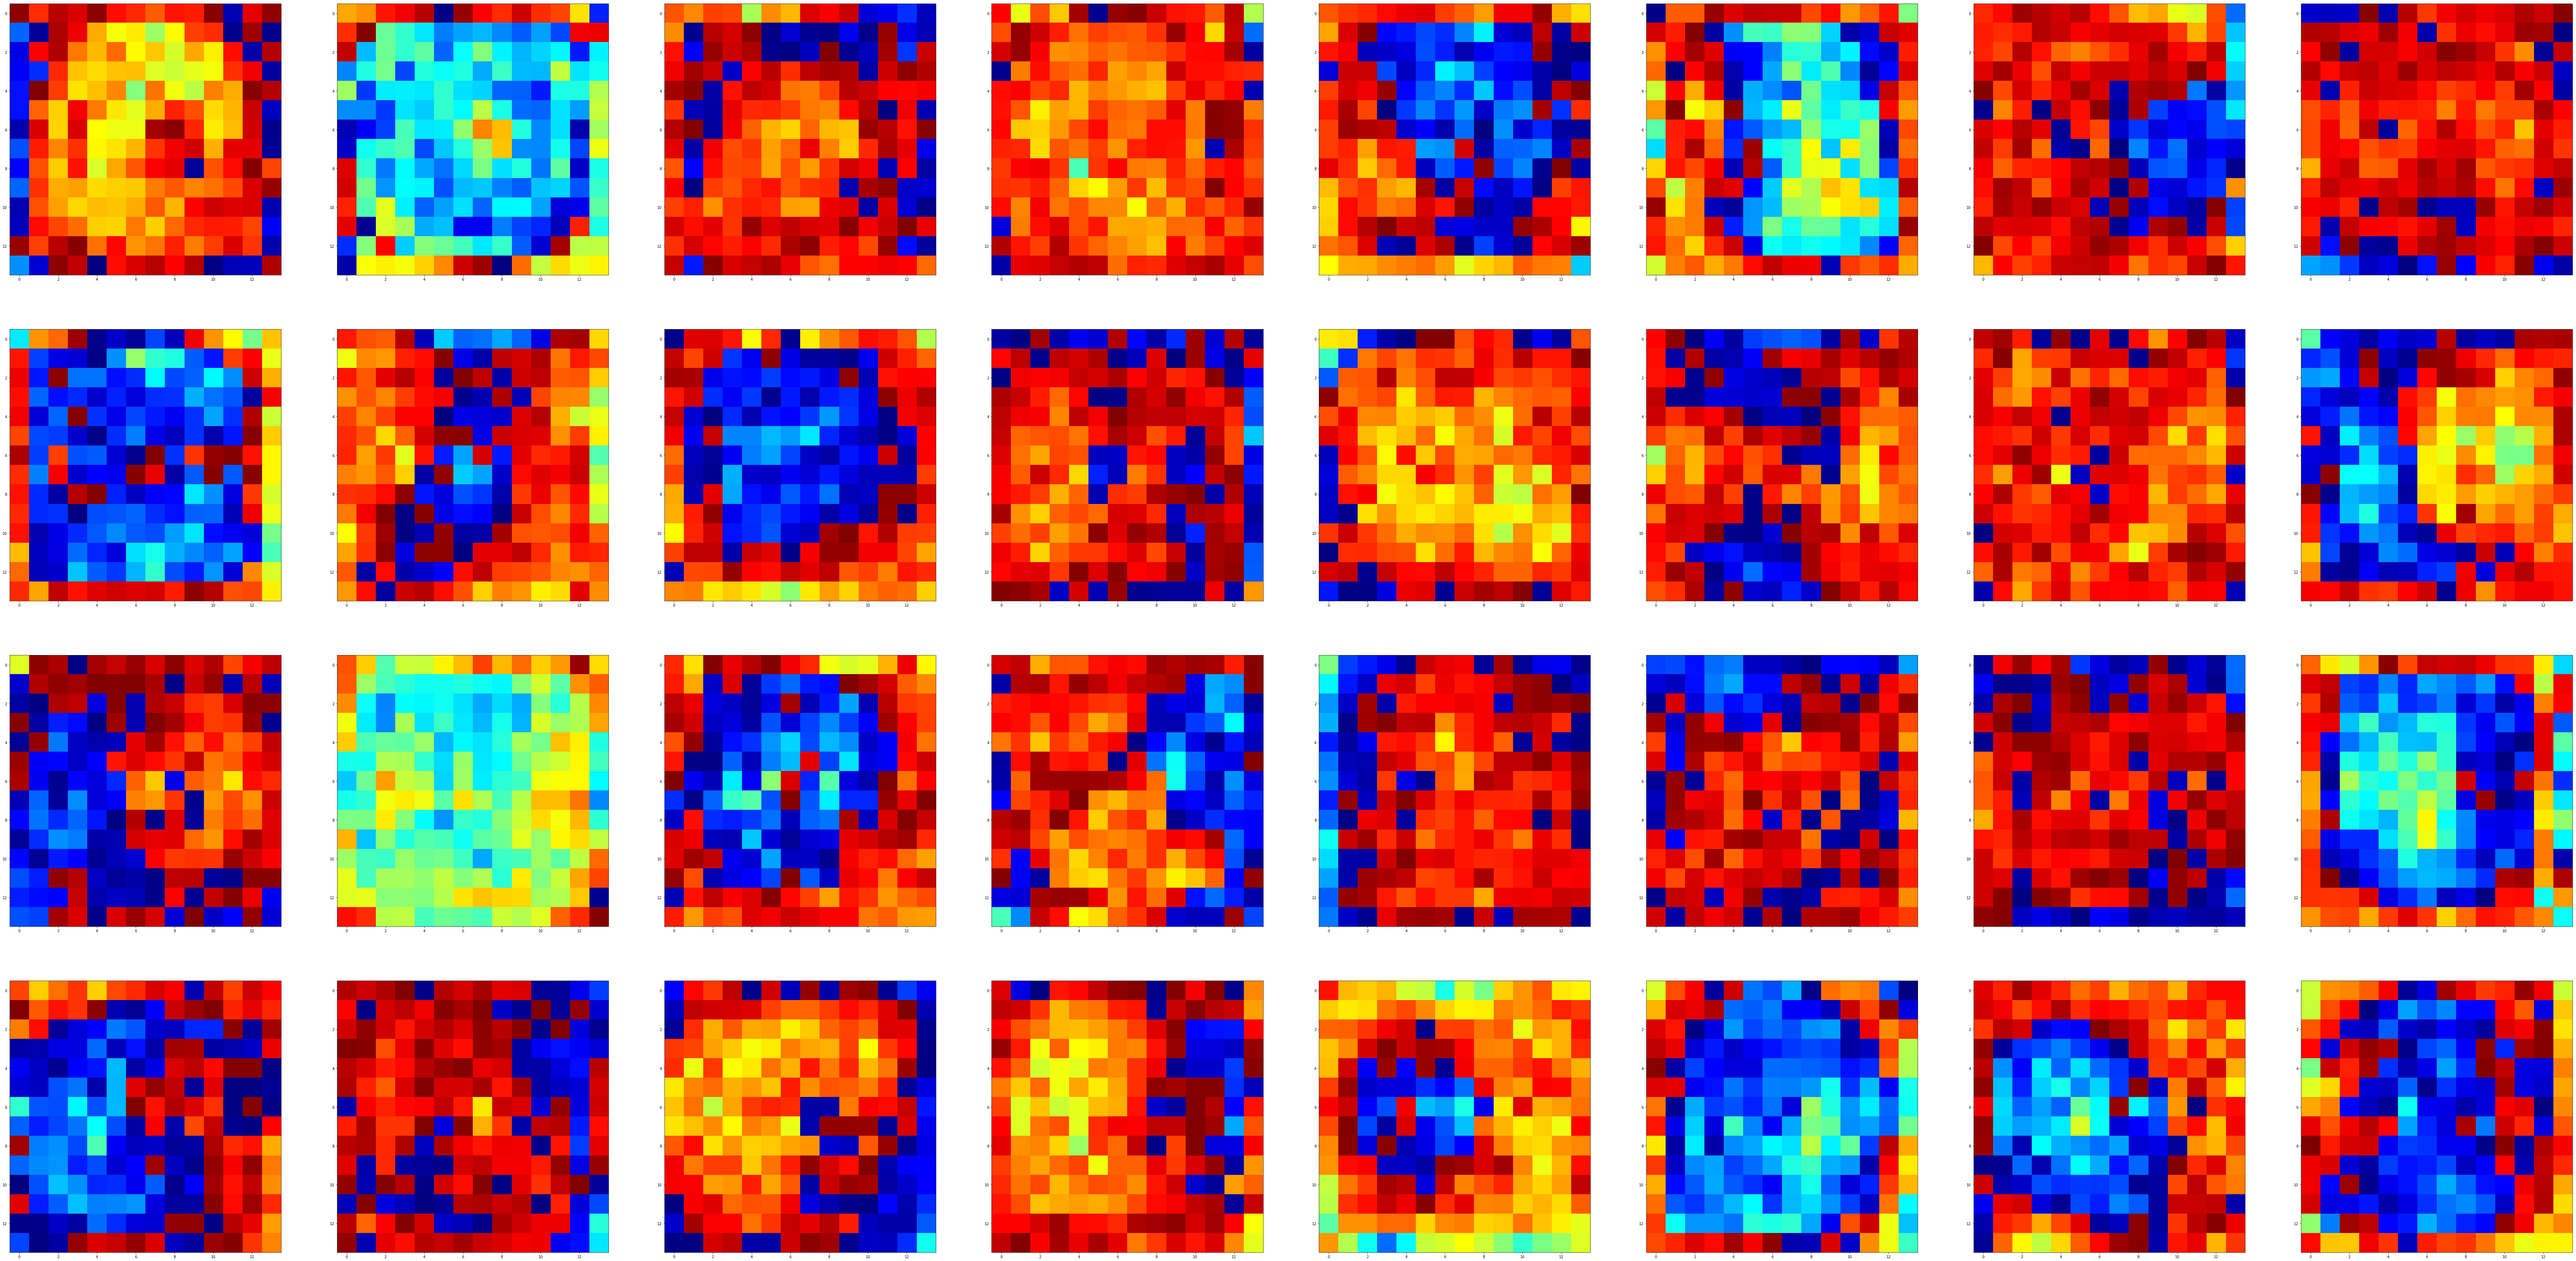

In [104]:
# reshaped_weight = classifier.weight[1].view(1, 32, 7, 7).detach().cpu().numpy()
reshaped_weight = classifier.weight[1].view(1, 32, 14, 14).detach().cpu().numpy()
reshaped_weight = (reshaped_weight - np.min(reshaped_weight)) / np.max(reshaped_weight) * 255
classweight = [cv2.applyColorMap(np.uint8(reshaped_weight[0, i, :, :]), cv2.COLORMAP_JET)[:, :, ::-1] for i in range(reshaped_weight.shape[1])]
ax = get_ax(rows=4, cols=8)
for i in range(len(classweight)):
    ax[i//8][i%8].imshow(classweight[i])
plt.show()

In [105]:
feature = feature.view(feature.size(0), -1)
score = classifier(feature)
print(score)
softmax = functional.softmax
prob = softmax(score, dim=1)
print(prob)

tensor([[29.8976, 22.9351]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[9.9905e-01, 9.4582e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)


tensor(0.0565, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0514, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3677, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.3867, device='cuda:0', grad_fn=<MaxBackward1>)


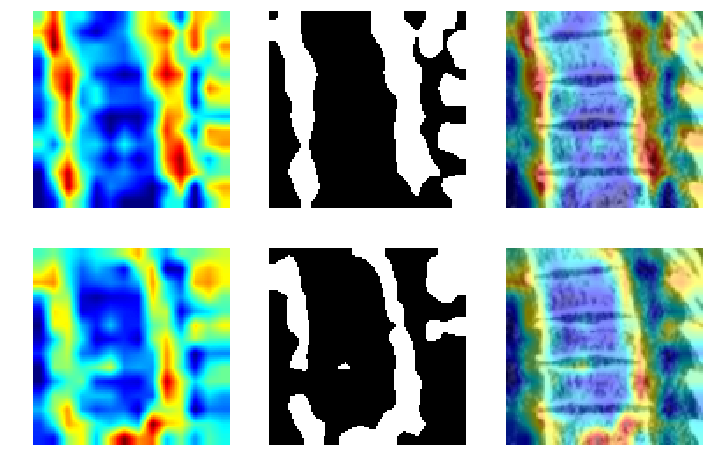

In [106]:
gap= nn.AvgPool2d(kernel_size=14)
relu = nn.ReLU(inplace=True)
# w = gap(classifier.weight[1].view(32, 7, 7))
# coarse_cam = torch.sum(feature.view(1, 32, 7, 7) * w, dim=1)
# coarse_cam = relu(coarse_cam)
# print(coarse_cam.size())
# cam = coarse_cam.cpu().detach().numpy()[0]
# print(cam.shape)
# cam = cv2.resize(cam, (112, 112))
# cam = cam - np.min(cam)
# cam = cam / np.max(cam)
w0 = gap(classifier.weight[0].view(32, 14, 14))
w1 = gap(classifier.weight[1].view(32, 14, 14))
cam_0 = relu(torch.sum(feature.view(1, 32, 14, 14) * w0, dim=1, keepdim=True))
cam_1 = relu(torch.sum(feature.view(1, 32, 14, 14) * w1, dim=1, keepdim=True))
# cam_0 = torch.sum(feature.view(1, 32, 7, 7) * w0, dim=1, keepdim=True)
# cam_1 = torch.sum(feature.view(1, 32, 7, 7) * w1, dim=1, keepdim=True)
print(torch.max(w0), torch.max(w1))
print(torch.max(cam_0), torch.max(cam_1))
cam_0 = functional.interpolate(cam_0, size=(112, 112), mode='bilinear', align_corners=False)
cam_1 = functional.interpolate(cam_1, size=(112, 112), mode='bilinear', align_corners=False)
cam_0 = cam_0 - torch.min(torch.min(cam_0, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_0 = cam_0 / torch.max(torch.max(cam_0, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_1 = cam_1 - torch.min(torch.min(cam_1, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_1 = cam_1 / torch.max(torch.max(cam_1, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
cam_0 = torch.where(cam_0 > 0.001, cam_0, torch.Tensor([0.001]).cuda())
cam_1 = torch.where(cam_1 > 0.001, cam_1, torch.Tensor([0.001]).cuda())
# cam_0 = torch.where(cam_0 < 0.5, cam_0, torch.Tensor([1.0]).cuda())
# cam_1 = torch.where(cam_1 < 0.5, cam_1, torch.Tensor([1.0]).cuda())
t_cam_0 = (cam_0 > 0.5).int()
t_cam_1 = (cam_1 > 0.5).int()

cam_0 = cam_0.cpu().detach().numpy()[0][0]
cam_1 = cam_1.cpu().detach().numpy()[0][0]
t_cam_0 = t_cam_0.cpu().detach().numpy()[0][0]
t_cam_1 = t_cam_1.cpu().detach().numpy()[0][0]

ax = get_ax(rows=2, cols=3, size=4)
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[0][2].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[1][2].axis('off')

heatmap_0 = cv2.applyColorMap(np.uint8(255 * cam_0), cv2.COLORMAP_JET)
heatmap_1 = cv2.applyColorMap(np.uint8(255 * cam_1), cv2.COLORMAP_JET)
ax[0][0].imshow(heatmap_0[:, :, ::-1])
ax[1][0].imshow(heatmap_1[:, :, ::-1])
ax[0][1].imshow(Image.fromarray(255 * t_cam_0))
ax[1][1].imshow(Image.fromarray(255 * t_cam_1))

img = cv2.resize(cv2.imread(image_path, 1), (112, 112))  # 这一步重新读入图片是为了将CAM图画在原图上
cam_0 = np.float32(heatmap_0) / 255 + np.float32(img) / 255
cam_1 = np.float32(heatmap_1) / 255 + np.float32(img) / 255
cam_0 = np.uint8(255 * cam_0 / np.max(cam_0))
cam_1 = np.uint8(255 * cam_1 / np.max(cam_1))
ax[0][2].imshow(cam_0[:, :, ::-1])
ax[1][2].imshow(cam_1[:, :, ::-1])
plt.show()